# Demo Pose Estimation

In [5]:
import cv2
import matplotlib.pyplot as plt
import mxnet as mx
from mxnet import gluon, nd
import numpy as np

from network.rtpose_vgg import get_model
from network.post import decode_pose
from training.datasets.coco_data.preprocessing import vgg_preprocess
from network import im_transform
from evaluate.coco_eval import get_multiplier, get_outputs, handle_paf_and_heat

### Loading pre-trained symbolic model

In [6]:
SIZE = 368

In [7]:
# Pick a compute context
ctx = mx.gpu() if mx.context.num_gpus() else mx.cpu()
# Load the model
net = gluon.nn.SymbolBlock.imports(
    symbol_file='model_checkpoints/inference_model-symbol.json',
    param_file='model_checkpoints/inference_model-0000.params',
    input_names=['data'],
    ctx=ctx)
# Hybridize for performance
net.hybridize(static_shape=True, static_alloc=True)
out = net(mx.nd.ones((1, 3, SIZE, SIZE), ctx=ctx)) #warm-up

## Detecting pose on sample image

In [8]:
test_image = './readme/example.png'
img = cv2.imread(test_image) # B,G,R order

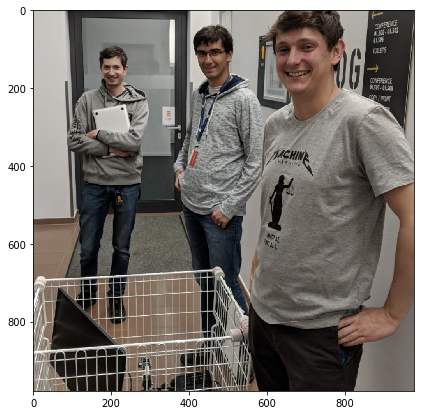

In [9]:
plt.figure(figsize=(7,7))
plt.imshow(img[:,:,::-1])

In [10]:
%%time
img = cv2.resize(img, (368,368))
shape_dst = np.min(img.shape[0:2])

# Get results of original image[
multiplier = [1]


orig_paf, orig_heat = get_outputs(multiplier, img, net,  'vgg', ctx=ctx)
          
# Get results of flipped image
swapped_img = img[:, ::-1, :]
flipped_paf, flipped_heat = get_outputs(multiplier, swapped_img, net, 'vgg', ctx=ctx)

# compute averaged heatmap and paf
paf, heatmap = handle_paf_and_heat(orig_heat, flipped_heat, orig_paf, flipped_paf)
            
param = {'thre1': 0.1, 'thre2': 0.05, 'thre3': 0.5}
canvas, to_plot, candidate, subset = decode_pose(img, param, heatmap, paf)

CPU times: user 464 ms, sys: 200 ms, total: 664 ms
Wall time: 406 ms


Results

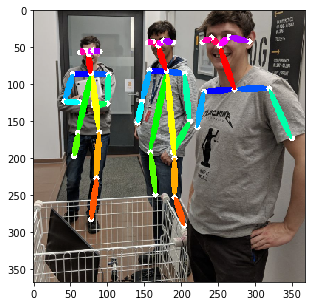

In [11]:
plt.figure(figsize=(5,5))
plt.imshow(to_plot[:,:,::-1])

### We can test the inference service 
This inference service has been optimized for speed in the case where there is a single person and we want only left and right wrist position

In [20]:
from model_serving.files.pose_service import pose_inference
from collections import namedtuple
f = open('readme/anton.png', 'rb')
data = [{'body':f.read()}]
Context = namedtuple('Context', ['system_properties'])
context = Context({'gpu_id':0, 'model_dir':'/home/ubuntu/tutorials/MultiPersonPoseEstimation_MXNet/model_checkpoints'})
out = pose_inference(data, context)
print(out)

[{'lw_x': 0.8478260869565217, 'lw_y': 0.42934782608695654, 'rw_x': 0.16032608695652173, 'rw_y': 0.4320652173913043}]


In [36]:
img = cv2.imread('readme/anton.png')

In [39]:
img = cv2.circle(img, (int(out[0]['lw_x']*img.shape[0]),int(out[0]['lw_y']*img.shape[1])), 20, (0,255,0), 10)
img = cv2.circle(img, (int(out[0]['rw_x']*img.shape[0]),int(out[0]['rw_y']*img.shape[1])), 20, (0,0,255), 10)

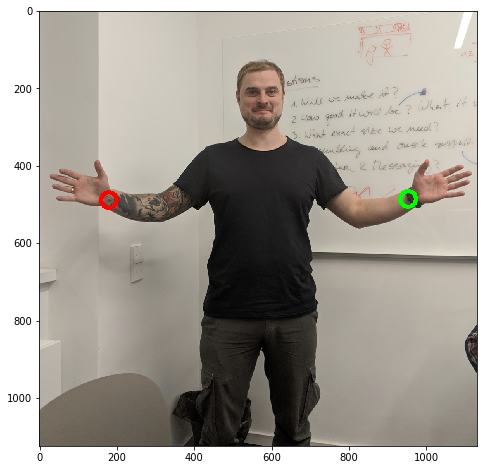

In [41]:
plt.figure(figsize=(8,8))
plt.imshow(img[:,:,::-1])